# Efficient determination of zero-crossings in noisy real-life time series
## Advanced Data Science Capstone Project
### Initial data exploration and generation of the problem. 
In this notebook, an initial problem exploration is performed. First, ten test problems from the literature are implemented as well as the well-known bouncing ball hybrid system. Then, the problems are generated on a uniform grid giving so the required dataset for the model evaluation. The plots of the test functions are presented. The first zero-crossings are also indicated on the graphs. Then, all the initial parameters for the simulation are fixed for the on-the-fly determination of the zero-crossings. 

All the functions used in this notebook, will be later moved to separate scripts in order to allow their calling from all notebooks.

Step 1. Importing of the libraries required at this step.  

In [ ]:
import math
from math import exp, sin, cos, log, pi
import numpy as np
import matplotlib.pyplot as plt

Step 2. Definition of the ten test problems from https://epubs.siam.org/doi/10.1137/S1064827599357590

1. The vectors `a, k, c` contain the randomized parameters required for the problem 6. 
2. The `functions_dict` is a dictionary containing the test functions as lambda functions with the key being the number of the function
3. The `minimal_roots_dict` is a dictionary containing the exact values of the first zero-crossing for each test problem.
4. `minimal_root_function` is a class containing the test function, its first zero-crossing, and the bounds of the time interval `[a,b]`

In [ ]:
a=[3.040,1.098,0.674,3.537,6.173,8.679,4.503,3.328,6.937,0.700]
k=[2.983,2.378,2.439,1.168,2.406,1.236,2.868,1.378,2.348,2.268]
c=[0.192,0.140,0.127,0.132,0.125,0.189,0.187,0.171,0.188,0.176]

functions_dict = {
      1: lambda x: -exp(sin(3.*x))+2.,
      2: lambda x: log(3.*x)*log(2.*x)-0.1,
      3: lambda x: cos(5*x) if x<=3.*pi/2. else cos(x),
      4: lambda x: 3.0-sin(2.*x+1.)-2.*sin(3.*x+2.)-3.*sin(4.*x+3.)-4.*sin(5.*x+4.)-5.*sin(6.*x+5.),
      5: lambda x: exp(-x)*sin(2.0*pi*x),
      6: lambda x: 10.0 - (1.0/(np.abs(k*(x-a))+c)).sum(),
      7: lambda x: x + sin(5.0*x),
      8: lambda x: -x + sin(3.0*x) + 1.,
      9: lambda x: sin(3.0*x) if x<=5 else 7.0*x*x-14.0*x-100.0,
      10: lambda x: cos(x)+2.0*cos(2.0*x)*exp(-x)
  }

minimal_roots_dict = {
      1: 0.2553,
      2: 0.2804,
      3: 0.3142,
      4: 0.4893,
      5: 0.5000,
      6: 0.6426,
      7: 0.8209,
      8: 1.0354,
      9: 1.0472,
      10: 1.1407
  }

class minimal_root_function():
    def __init__(self, func_number = 1):
        self.f = functions_dict[func_number]
        self.MR = minimal_roots_dict[func_number]
        self.a = 0.1
        self.b = 7.0

Step 3. Definition of the Bouncing ball hybrid system. 
The system is defined by the variables $x(t) = (x_1(t), x_2(t))$, where $x_1(t)$ is the altitude of the ball and $x_2(t) = \dot{x_1}(t)$ is the velocity of the ball, which are changed according to the following dynamics ($g$ is the gravitational acceleration $\approx 9.81$): 
$$\begin{cases}
\dot{x}_1(t) = x_2(t)\\
\dot{x}_2(t) = -g,
\end{cases}$$
The discrete events occur, when the ball touches the ground: 
If $x_1(t) \leq r$, then $x_2(t) := -c \cdot x_2(t-1)$, where $r$ is the ground level (see, e.g., https://www3.nd.edu/~isis/hybrid_examples/example_I/#x1-20001 ). 
1. The class `ball_sim' creates an instance of the simulated hybrid system. For each instance, it assignes the 2-D array of the system variables $x(t) = (x_1(t),x_2(t))$, set to the initial value $x_0 = (x_1(t_0), x_2(t_0))$ at the initialization step; the 1-D vector of the time observations $t$ (first, set to the initial time $t_0$); the constant $c,~c\in (0,1);$ the final time $T$; the stepsize $h$ and the 1-D vector $ground$ containing the values of the ground level $r$.
2. The method `func(x,t)` assignes the changing dynamics of the system being the system of the ordinary differential equations (ODEs). It has the default value `t = 0`, since in practice the autonomous case arises frequently in real-life problems, i.e., the right-side function in the ODEs does not depend on $t$. 
3. The method `solve(x0,t0)` contains the method for solving the ODEs numerically. The standard and well-known Runge-Kutta method of order 4 (RK4) has been implemented just for simplicity (see https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods )
4. The method `step(g_lev)` implements the one step of simulation, where `g_lev = g_lev(t,x)` is the function, which returns the ground level at time $t$. This method returns the new observation $t_{k+1}$, the system variables $x(t_{k+1})$, the ground level $ground_{k+1}$ at $t = t_{k+1}$ and append all new values to the respective arrays. 
5. The method `simulate` implements the full simulation of the system including the plots of the function variables $x_1(t)$ and $x_2(t)$, the ground level $r(t)$ and the respective function $g(t,x) = x_1(t) - r(t)$, for which the zero-crossings are determined. 

In [ ]:
class ball_sim():
    def __init__(self,x0 = [0.0,0.0], t0 = 0.0, c = 0.75, T = 10., h = 0.5,g_lev = lambda t,x: 0.0):
        self.x = np.array([np.array(x0)])
        self.t = np.array([t0])
        self.c = c
        self.T = T
        self.h = h
        self.ground = np.array([g_lev(self.t[0],self.x[0])])
    def func(self,x,t=0):
        y = np.array(x,float)
        y[0] = x[1]
        y[1] = -9.81
        return y
    def solve(self,x0,t0):
        k1 = self.func(x0,t0)
        k2 = self.func(x0+self.h*k1/2,t0+self.h/2)
        k3 = self.func(x0+self.h*k2/2,t0+self.h/2)
        k4 = self.func(x0+self.h*k3,t0+self.h)
        y = x0+(self.h/6.)*(k1+2*k2+2*k3+k4)
        return y
    def step(self,g_lev):
        x_new = self.solve(self.x[-1],self.t[-1])
        t_new = self.t[-1]+self.h
        r = g_lev(t_new,x_new)
        if x_new[0] <= r:
            x_new[0] = r
            x_new[1] = -self.c*self.x[-1][1]
        self.x = np.append(self.x,np.array([x_new]),axis=0)
        self.t = np.append(self.t,t_new)
        self.ground = np.append(self.ground,r)
        return 0
    def simulate(self,g_lev):
        while self.t[-1]<self.T-self.h/10000:
            self.step(g_lev)
        fig = plt.figure(figsize=(10,8))
        ax1 = fig.add_subplot(311)
        ax2 = fig.add_subplot(312)
        ax3 = fig.add_subplot(313)
        ax1.plot(self.t,self.x[:,0],'blue')
        ax1.plot(self.t,self.ground,'red')
        fig.suptitle('Simulation of the bouncing ball')
        ax1.set_xlabel('time')
        ax1.set_ylabel('altitude')
        ax1.legend(['altitude','ground'])
        ax1.grid(True)
        ax2.plot(self.t,self.x[:,1],'black')
        ax2.set_xlabel('time')
        ax2.set_ylabel('velocity')
        ax2.legend(['velocity'])
        ax2.grid(True)
        ax3.plot(self.t,self.x[:,0]-self.ground,'blue')
        zero_crossing_pos = abs(self.x[:,0]-self.ground)==0
        ax3.plot(self.t[zero_crossing_pos],(self.x[:,0]-self.ground)[zero_crossing_pos],'ro')
        ax3.set_xlabel('time')
        ax3.set_ylabel('altitude')
        ax3.legend(['relative altitude w.r.t. ground level','zero-crossings'])
        ax3.grid(True)
        fig.savefig('Bouncing_ball'+str(self.ground[0])+'.png')

Step 4. Generate the datasets and fix the simulation parameters for the selected test problem. Just for simplicity, it is supposed that the test problems number 1-10 belong to the first class of test problems, while the problems -1, -2 belong to the second class (i.e., the bouncing ball problem with two different ground level functions). This method returns the following values: 
`t,x,t0,T,h,N_samples_per_unit,prediction_steps,first_zero,zero_points,sigma`,
where `t` is the array of the observations of time, `x` is 1-D array of the values of the function, for which the zero-crossings are determined (being the values of the test functions for the problems of the first class or the values $x_1(t) - r(t)$ for the bouncing ball), `t0` is the initial time point, `T` is the final time point, `h` is the stepsize being the difference between two consecutive time points $h = t_{k+1} - t_k$, `N_samples_per_unit` is the number of time steps used for training the models on-the-fly (i.e., the left side of the window during the forecasting the time series), `prediction_steps` is the number of the time steps predicted by the model using `N_samples_per_unit` previous time steps, `first_zero` is the a priori given time of the first zero-crossing (required for the evaluation of the models), `zero_points` is the array of all zero-crossings on the interval $[t_0,T]$, `sigma` is the standard deviation of the noise, which will be applied to $x$ during the simulation (the value `sigma = 0` can be used as well for simulation without noise). 

For the Bouncing ball system, two different ground level functions are used:
1. A simple constant case $r(t) = 1$.
2. A difficult nonlinear function $r(t) = 5\sin(t)\sqrt{\sin^2(x_1) + \sin^2(x_2)}$.


In [ ]:
def generate_problem(fnum):
    if fnum>0:
      f = minimal_root_function(fnum)
      t0 = f.a
      T = f.b
      N = int((T-t0)*15000)
      h = (T-t0)/N
      t = np.arange(t0,T,h)
      x = []
      curr_sign = 1
      zero_points = []
      for i in range(t.shape[0]):
          x.append(f.f(t[i]))
          if np.sign(x[-1])*curr_sign <=0:
              if curr_sign ==1:
                  curr_sign = -1
              else:
                  curr_sign = 1
              if abs(x[-1])<=abs(x[-2]):
                  zero_points.append(t[i])
              else:
                  zero_points.append(t[i-1])
      first_zero = f.MR
    else:
      t0 = 0.
      T = 10.
      c = 0.75
      N = T*10000
      h = (T-t0)/N
      x0 = [10.,15.]
      def g_level(t,x):
        if fnum==-1:
          return 1.0
        else:
          return 5*math.sin(t)*math.sqrt(math.sin(x[0])**2 + math.sin(x[1])**2)
      ball_sim_process = ball_sim(x0,t0,c,T,h,g_level)
      ball_sim_process.simulate(g_level)
      t = ball_sim_process.t
      x = ball_sim_process.x[:,0]-ball_sim_process.ground
      zero_points = t[(abs(x)==0)]
      first_zero = zero_points[0]
    x = np.array(x)
    zero_points = np.array(zero_points)
    N_samples_per_unit = 1000
    prediction_steps = 100
    sigma = 0.01
    
    return t,x,t0,T,h,N_samples_per_unit,prediction_steps,first_zero,zero_points,sigma

Step 5. Initial data exploration. 
Generate the functions and visualize all the graphs indicating the first zero-crossing as well.


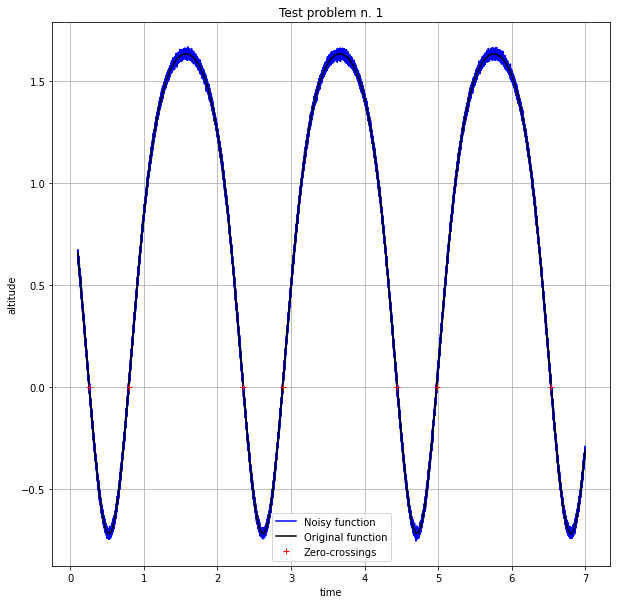

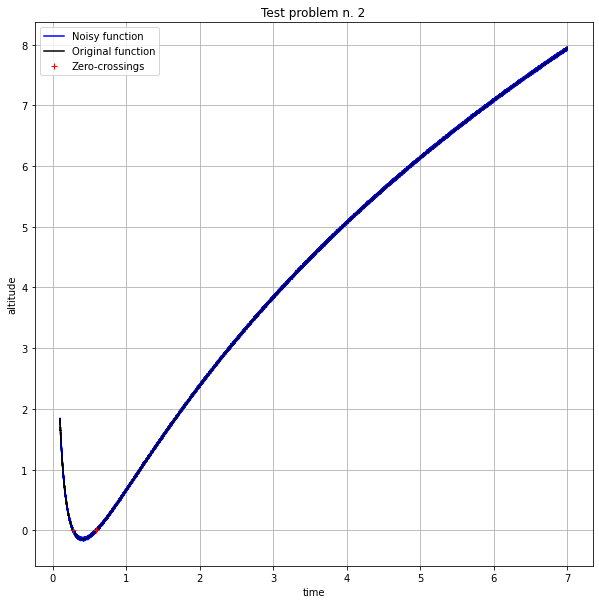

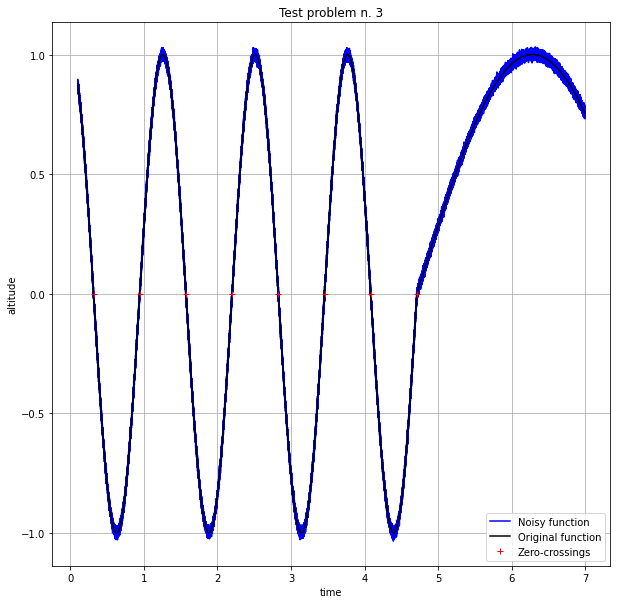

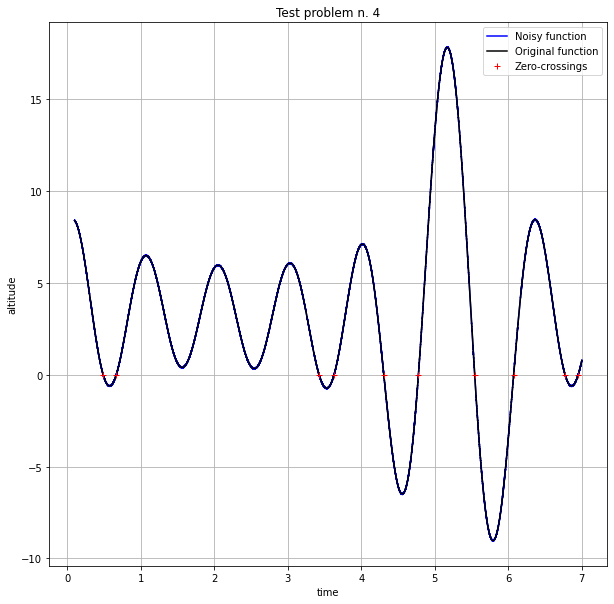

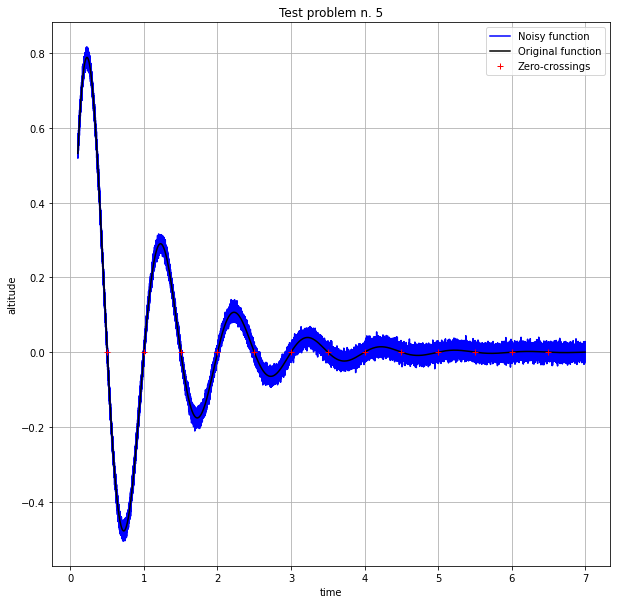

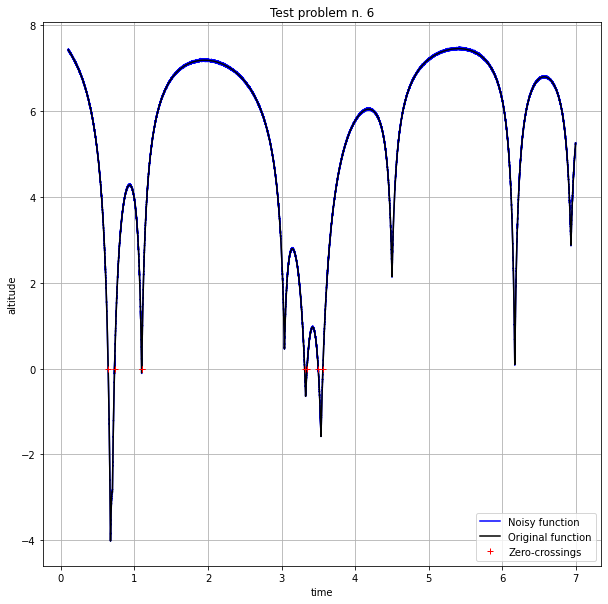

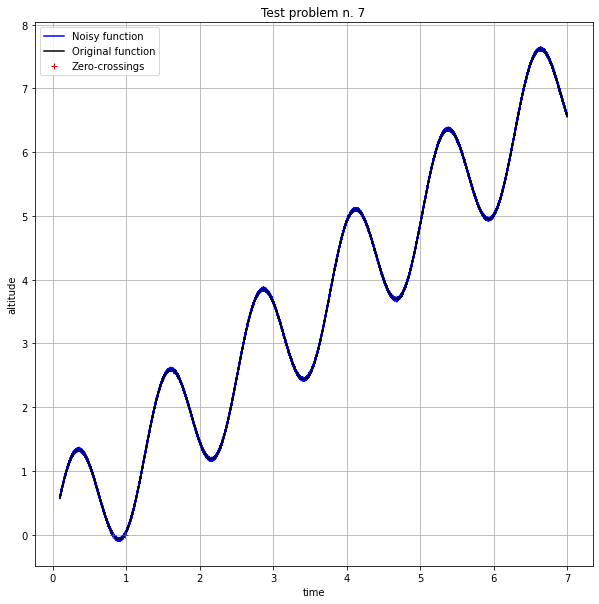

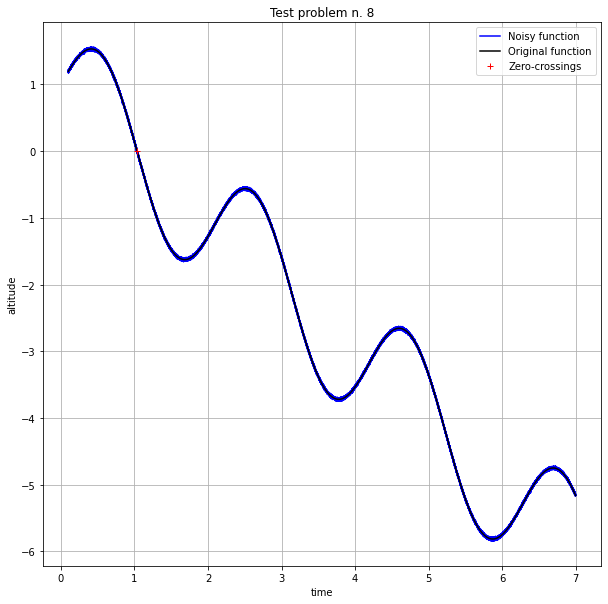

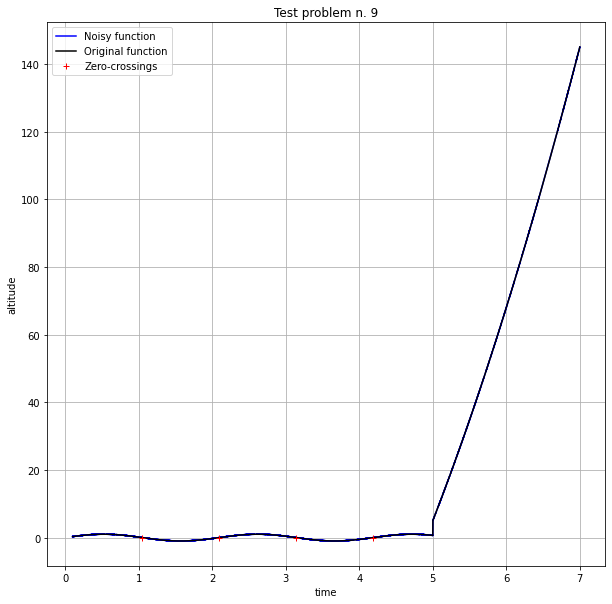

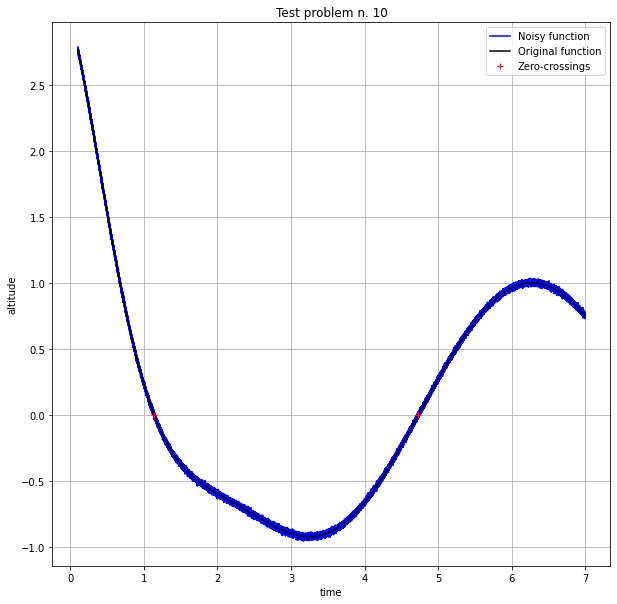

In [ ]:
for fnum in range(1,11):
  fig = plt.figure(figsize=(10,10))
  np.random.seed(fnum)
  t,x,t0,T,h,N_samples_per_unit,prediction_steps,first_zero,zero_points,sigma = generate_problem(fnum)
  ax = fig.add_subplot(1,1,1)
  ax.plot(t,x+np.random.normal(0,sigma,t.shape[0]),'blue')
  ax.plot(t,x,'black')
  ax.plot(zero_points,np.zeros((zero_points.shape)),'r+')
  ax.set_xlabel('time')
  ax.set_ylabel('altitude')
  ax.legend(['Noisy function','Original function', 'Zero-crossings'])
  ax.grid(True)
  ax.set_title('Test problem n. '+str(fnum))
  fig.savefig('test_problem_n.'+str(fnum)+'.png')


We see that the problems are all different. For example, the problems number 1,3,8,10 are more simple, since both the regions before and after the first zero-crossing, where the function is positive/negative are wide, so it is difficult to skip the first zero-crossing in these case. However, e.g., the problems 2, 4, 6, 7 are more difficult, since they are negative only on a small sub-interval, so it is much easier to skip the first zero-crossing in these cases. Moreover, the functions number 5 and 9 are different from the previous ones, since the function n. 5 is more affected by the noise, while the function 8 is very flat and small on the initial subintervals, so it is also easy to skip a correct zero-crossing. 

We see also that all the functions have difficult nonlinear structure, making so their good approximation a challenging problem. Let us study now the bouncing ball system in the same way.

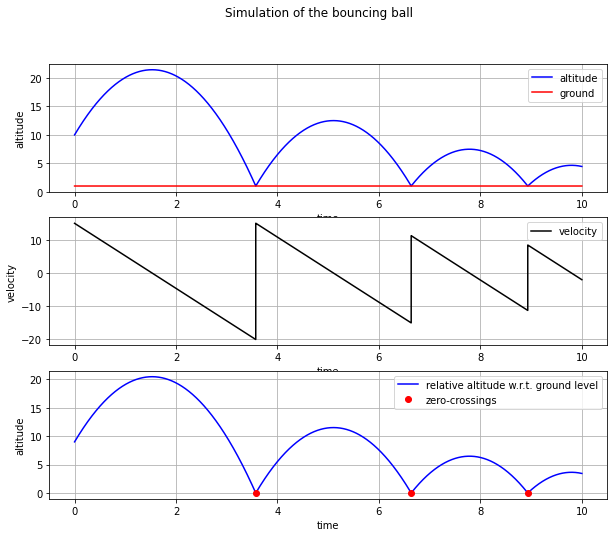

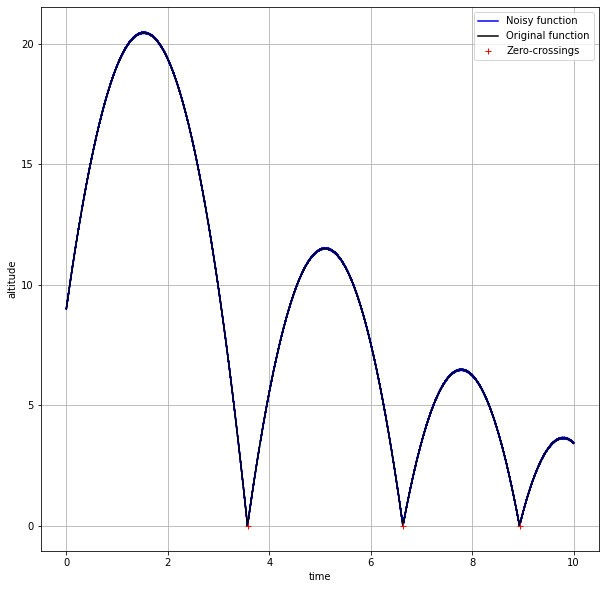

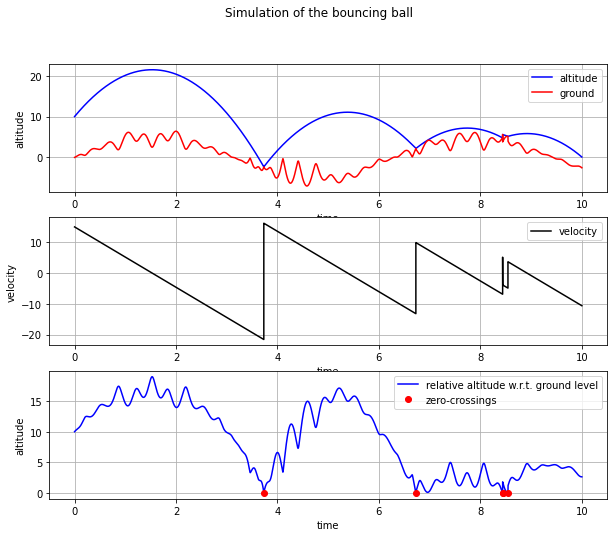

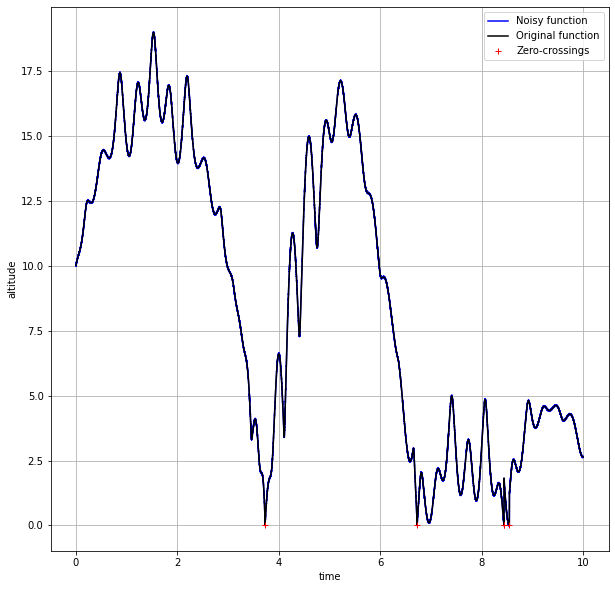

In [ ]:
for fnum in range(1,3):
  np.random.seed(fnum)
  t,x,t0,T,h,N_samples_per_unit,prediction_steps,first_zero,zero_points,sigma = generate_problem(-fnum)
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1,1,1)
  ax.plot(t,x+np.random.normal(0,sigma,t.shape[0]),'blue')
  ax.plot(t,x,'black')
  ax.plot(zero_points,np.zeros((zero_points.shape)),'r+')
  ax.set_xlabel('time')
  ax.set_ylabel('altitude')
  ax.legend(['Noisy function','Original function', 'Zero-crossings'])
  ax.grid(True)
  fig.savefig('bouncing_ball_noisy_n.'+str(fnum)+'.png')


We see that the objective function (i.e., the function, for which the zero-crossings are determined) has also a nonlinear structure. Moreover, it only ``touches'' the zero-level and never goes below it, so the determination of the zero-crossings in this case becomes even more challenging than in the previous cases. The second case, when the ground level is also nonlinear, the objective function becomes much more difficult, since it has a complicated nonlinear structure with a lot of ill-conditioned local optima with several global optima being also the zero-crossings. Noise does not affect a lot on the structure of the function (at least with the used value of $\sigma$), but even without it the problem remains difficult. 

In all the cases we see that the objective function can have a lot of local optimums, so we need an efficient method not only to approximate the "trend" of the function, but also to approximate well its local oscillations, since one of the can lead to a zero-crossing. 